## Import Library

In [1]:
!pip install gdown

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import pickle
import math
from math import log
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from scipy import optimize
from joblib import Parallel, delayed
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from scipy.stats import mode
import time

## Import Pre-processed Data

In [3]:
!mkdir -p content/data
# Download all files
file_ids = [
    '1fdbbwFuXm0zrXYi3i9MvCqilA9i7OcZq',  # X_train
    '1-1iUTztO9XpxwzF02JhoW3pdMs5jKrw1',  # X_train_resampled
    '1-39uqbcZldsGLgDKYfxIHsSNGewMXJRR',  # X_test
    '1Ms25aS5NADPDYdt8AGAUyYIjbdBvKGFZ',  # X_test_resampled
    '1-CChPe58Z6E-H6EXIzKsgUhqbITAd54z',  # Y_train
    '1D3wYlWZbt5NeM59QTA1JaVVvnaAZzFUf',  # Y_train_resampled
    '1-CUpVhcZ6-Qop7R9Z6Btb2gEf7f0XgGy'   # Y_test
]

file_paths = [
    'content/data/X_train.pkl',
    'content/data/X_train_resampled.pkl',
    'content/data/X_test.pkl',
    'content/data/X_test_resampled.pkl',
    'content/data/Y_train.pkl',
    'content/data/Y_train_resampled.pkl',
    'content/data/Y_test.pkl'
]
for file_id, file_path in zip(file_ids, file_paths):
    gdown.download(f'https://drive.google.com/uc?id={file_id}', file_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1fdbbwFuXm0zrXYi3i9MvCqilA9i7OcZq
To: /content/content/data/X_train.pkl
100%|██████████| 21.4M/21.4M [00:00<00:00, 77.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1iUTztO9XpxwzF02JhoW3pdMs5jKrw1
To: /content/content/data/X_train_resampled.pkl
100%|██████████| 18.7M/18.7M [00:00<00:00, 66.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-39uqbcZldsGLgDKYfxIHsSNGewMXJRR
To: /content/content/data/X_test.pkl
100%|██████████| 5.35M/5.35M [00:00<00:00, 34.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ms25aS5NADPDYdt8AGAUyYIjbdBvKGFZ
To: /content/content/data/X_test_resampled.pkl
100%|██████████| 5.35M/5.35M [00:00<00:00, 29.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-CChPe58Z6E-H6EXIzKsgUhqbITAd54z
To: /content/content/data/Y_train.pkl
100%|██████████| 2.79M/2.79M [00:00<00:00, 19.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D3wYlWZbt5NeM59QTA1JaVVvnaAZzFUf
To: /conten

In [4]:
X_train = pd.read_pickle('content/data/X_train.pkl')
X_train_resampled = pd.read_pickle('content/data/X_train_resampled.pkl')
X_test = pd.read_pickle('content/data/X_test.pkl')
X_test_resampled = pd.read_pickle('content/data/X_test_resampled.pkl')
y_train = pd.read_pickle('content/data/Y_train.pkl')
y_train_resampled = pd.read_pickle('content/data/Y_train_resampled.pkl')
y_test = pd.read_pickle('content/data/Y_test.pkl')

In [5]:
result_acc = []
result_recall = []
pred_time = []

## 1. Decision Tree - Thư viện

### 1.1 No resampled

In [6]:
param_grid_maxdepth = {'max_depth': [5, 10, 15, 20, 50]}
criterions = ['gini', 'entropy']
results = {}

for criterion in criterions:
    grid_search = GridSearchCV(DecisionTreeClassifier(criterion=criterion),
                               param_grid_maxdepth, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    results[criterion] = {
        'mean_accuracy': grid_search.cv_results_['mean_test_score'],
        'std_accuracy': grid_search.cv_results_['std_test_score']
    }
    best_params = grid_search.best_params_  # Lấy tham số tốt nhất
    best_accuracy = grid_search.best_score_  # Lấy độ chính xác tốt nhất
    print(f"Criterion: {criterion}")
    print(f"Best max_depth: {best_params['max_depth']}, Best Accuracy: {best_accuracy:.4f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Criterion: gini
Best max_depth: 10, Best Accuracy: 0.8486
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Criterion: entropy
Best max_depth: 10, Best Accuracy: 0.8478


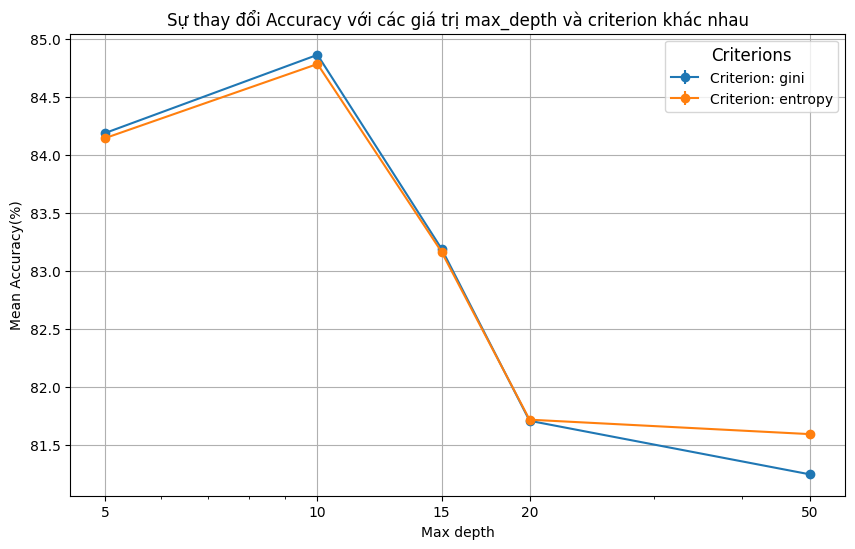

In [7]:
plt.figure(figsize=(10, 6))

for criterion in criterions:
    mean_acc = results[criterion]['mean_accuracy']*100
    std_acc = results[criterion]['std_accuracy']
    plt.errorbar(param_grid_maxdepth['max_depth'], mean_acc, yerr=std_acc, label=f"Criterion: {criterion}", fmt='o-')

plt.xscale('log')  # Biểu đồ theo log scale
plt.xticks(param_grid_maxdepth['max_depth'], labels=[str(c) for c in param_grid_maxdepth['max_depth']])
plt.xlabel("Max depth")
plt.ylabel("Mean Accuracy(%)")
plt.title("Sự thay đổi Accuracy với các giá trị max_depth và criterion khác nhau")
plt.legend(title="Criterions", loc="best", fontsize=10, title_fontsize=12)
plt.grid()
plt.show()

In [8]:
dt=DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)
dt.fit(X_train,y_train)

# Dự đoán trên tập Test
start_time = time.time()
y_pred = dt.predict(X_test)
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")
acc = accuracy_score(y_test, y_pred) * 100
result_acc.append(acc)
print(f"Accuracy on Test set: {acc:.2f}%")

Time to predict: 0.0071 seconds
Accuracy on Test set: 85.15%


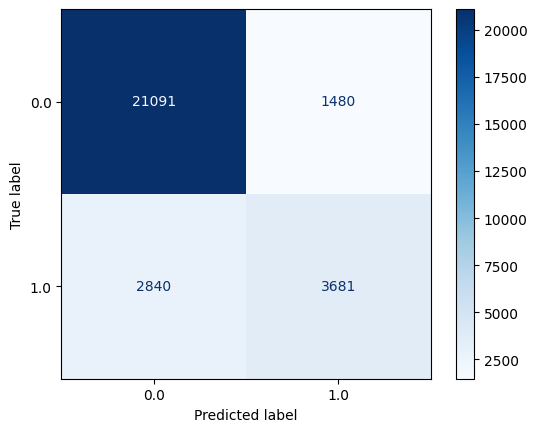

<Figure size 1200x1200 with 0 Axes>

In [9]:
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, cmap='Blues')
plt.figure(figsize=(12, 12))
plt.show();

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.93      0.91     22571
         1.0       0.71      0.56      0.63      6521

    accuracy                           0.85     29092
   macro avg       0.80      0.75      0.77     29092
weighted avg       0.84      0.85      0.85     29092



In [11]:
recall_s = recall_score(y_test, dt.predict(X_test), average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall_s[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall_s[0])
result_recall.append(recall_s)

Tỉ lệ dự đoán đúng ngày mai có mưa là  0.5644839748504831
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 0.9344291347304062


### 1.2 Resampled

In [12]:
param_grid_maxdepth = {'max_depth': [5, 10, 15, 20, 50]}
criterions = ['gini', 'entropy']
results = {}

for criterion in criterions:
    grid_search = GridSearchCV(DecisionTreeClassifier(criterion=criterion),
                               param_grid_maxdepth, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train_resampled, y_train_resampled)
    results[criterion] = {
        'mean_accuracy': grid_search.cv_results_['mean_test_score'],
        'std_accuracy': grid_search.cv_results_['std_test_score']
    }
    best_params = grid_search.best_params_  # Lấy tham số tốt nhất
    best_accuracy = grid_search.best_score_  # Lấy độ chính xác tốt nhất
    print(f"Criterion: {criterion}")
    print(f"Best max_depth: {best_params['max_depth']}, Best Accuracy: {best_accuracy:.4f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Criterion: gini
Best max_depth: 10, Best Accuracy: 0.8095
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Criterion: entropy
Best max_depth: 10, Best Accuracy: 0.8114


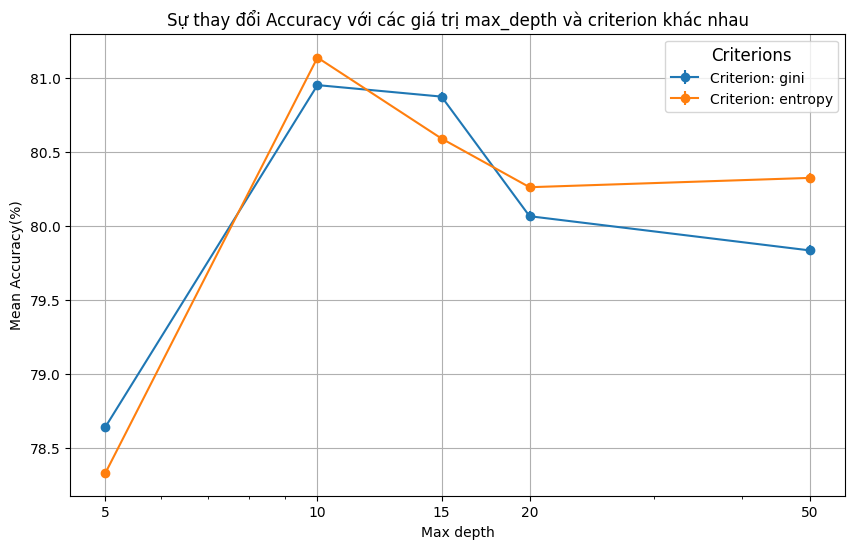

In [13]:
plt.figure(figsize=(10, 6))

for criterion in criterions:
    mean_acc = results[criterion]['mean_accuracy']*100
    std_acc = results[criterion]['std_accuracy']
    plt.errorbar(param_grid_maxdepth['max_depth'], mean_acc, yerr=std_acc, label=f"Criterion: {criterion}", fmt='o-')

plt.xscale('log')  # Biểu đồ theo log scale
plt.xticks(param_grid_maxdepth['max_depth'], labels=[str(c) for c in param_grid_maxdepth['max_depth']])
plt.xlabel("Max depth")
plt.ylabel("Mean Accuracy(%)")
plt.title("Sự thay đổi Accuracy với các giá trị max_depth và criterion khác nhau")
plt.legend(title="Criterions", loc="best", fontsize=10, title_fontsize=12)
plt.grid()
plt.show()

In [14]:
dt_res=DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
dt_res.fit(X_train_resampled, y_train_resampled)

# Dự đoán trên tập Test
start_time = time.time()
y_pred = dt_res.predict(X_test_resampled)
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")
acc = accuracy_score(y_test, y_pred) * 100
result_acc.append(acc)
print(f"Accuracy on Test set: {acc:.2f}%")

Time to predict: 0.0094 seconds
Accuracy on Test set: 82.69%


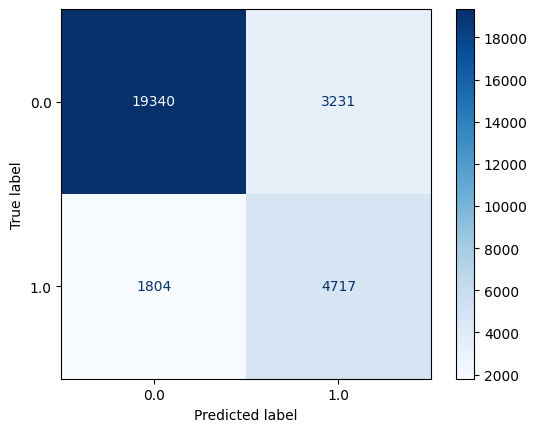

<Figure size 1200x1200 with 0 Axes>

In [15]:
ConfusionMatrixDisplay.from_estimator(dt_res, X_test_resampled, y_test, cmap='Blues')
plt.figure(figsize=(12, 12))
plt.show();

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88     22571
         1.0       0.59      0.72      0.65      6521

    accuracy                           0.83     29092
   macro avg       0.75      0.79      0.77     29092
weighted avg       0.84      0.83      0.83     29092



In [17]:
recall_s = recall_score(y_test, y_pred, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall_s[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall_s[0])
result_recall.append(recall_s)

Tỉ lệ dự đoán đúng ngày mai có mưa là  0.7233553136022083
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 0.8568517123742856


## 2. Decision Tree - Tự code

In [18]:
class CustomDecisionTree:
    def __init__(self, max_depth=10, batch_size=4096, n_jobs=4):
        self.max_depth = max_depth
        self.batch_size = batch_size
        self.n_jobs = n_jobs
        self.tree = None

    def _entropy(self, y):
        """Tính entropy cho nhãn y."""
        y = y.astype(int)  # Ép kiểu y về int để tránh lỗi với np.bincount
        class_counts = np.bincount(y)
        probs = class_counts / len(y)
        probs = probs[probs > 0]  # Loại bỏ các xác suất bằng 0
        return -np.sum(probs * np.log2(probs))

    def _find_best_split(self, X, y):
        """Tìm điểm phân chia tốt nhất cho batch dữ liệu."""
        y = y.astype(int)  # Đảm bảo y là int trước khi sử dụng
        best_entropy = float('inf')
        best_split = None
        n_samples, n_features = X.shape

        for feature in range(n_features):
            unique_values = np.unique(X[:, feature])
            for threshold in unique_values:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                left_y = y[left_mask]
                right_y = y[right_mask]

                entropy_left = self._entropy(left_y)
                entropy_right = self._entropy(right_y)
                weighted_entropy = (len(left_y) * entropy_left + len(right_y) * entropy_right) / len(y)

                if weighted_entropy < best_entropy:
                    best_entropy = weighted_entropy
                    best_split = {
                        'feature': feature,
                        'threshold': threshold,
                        'left': left_mask,
                        'right': right_mask
                    }
        return best_split

    def _build_tree(self, X, y, depth=0):
        """Xây dựng cây quyết định."""
        y = y.astype(int)  # Đảm bảo y là int trước khi dùng trong cây
        if depth >= self.max_depth or len(np.unique(y)) == 1:
            return np.bincount(y).argmax()

        best_split = self._find_best_split(X, y)
        if best_split is None:
            return np.bincount(y).argmax()

        left_X, left_y = X[best_split['left']], y[best_split['left']]
        right_X, right_y = X[best_split['right']], y[best_split['right']]

        left_tree = self._build_tree(left_X, left_y, depth + 1)
        right_tree = self._build_tree(right_X, right_y, depth + 1)

        return {
            'feature': best_split['feature'],
            'threshold': best_split['threshold'],
            'left': left_tree,
            'right': right_tree
        }

    def _train_tree_parallel(self, X_batch, y_batch):
        """Huấn luyện cây quyết định cho mỗi batch song song."""
        y_batch = y_batch.astype(int)  # Đảm bảo y_batch là int
        return self._build_tree(X_batch, y_batch)

    def fit(self, X, y):
        """Huấn luyện cây quyết định theo từng batch và song song."""
        y = y.astype(int)  # Đảm bảo y là int trước khi bắt đầu huấn luyện
        n_samples = X.shape[0]
        trees = []

        # Chia dữ liệu thành các batch
        batch_indices = [(i, min(i + self.batch_size, n_samples)) for i in range(0, n_samples, self.batch_size)]

        # Sử dụng Parallel để huấn luyện các cây cho các batch
        trees = Parallel(n_jobs=self.n_jobs)(
            delayed(self._train_tree_parallel)(X[start:end], y[start:end])
            for start, end in batch_indices
        )

        # Kết hợp các cây thành một cây quyết định duy nhất
        self.tree = trees

    def _predict_tree(self, X, tree):
        """Dự đoán với một cây quyết định đã huấn luyện."""
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples)

        for i in range(n_samples):
            node = tree
            while isinstance(node, dict):
                if X.iloc[i, node['feature']] <= node['threshold']:
                    node = node['left']
                else:
                    node = node['right']
            predictions[i] = node
        return predictions

    def predict(self, X):
        """Dự đoán cho mỗi mẫu từ tất cả các cây quyết định."""
        all_predictions = np.zeros((X.shape[0], len(self.tree)))

        # Dự đoán cho mỗi cây và kết hợp kết quả
        for i, tree in enumerate(self.tree):
            # Đảm bảo X là numpy array, nếu X là DataFrame
            if isinstance(X, pd.DataFrame):
                all_predictions[:, i] = self._predict_tree(X, tree)
            else:
                all_predictions[:, i] = self._predict_tree(pd.DataFrame(X), tree)  # Chuyển X thành DataFrame nếu nó là numpy array

        # Trả về nhãn dự đoán cuối cùng (chọn nhãn phổ biến nhất)
        # return np.round(np.mean(all_predictions, axis=1))
        return mode(all_predictions, axis=1)[0].flatten()
    def score(self, X, y):
        """Đánh giá độ chính xác của mô hình."""
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

### 2.1 No resampled

In [19]:
dt_by_hand=CustomDecisionTree(max_depth=10, batch_size=4096, n_jobs=4)
dt_by_hand.fit(X_train.values, y_train.values)

# Dự đoán trên tập Test
start_time = time.time()
y_pred_by_hand = dt_by_hand.predict(X_test)
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")
acc = accuracy_score(y_test, y_pred_by_hand) * 100
result_acc.append(acc)
print(f"Accuracy on Test set: {acc:.2f}%")

Time to predict: 184.8607 seconds
Accuracy on Test set: 85.98%


In [20]:
print(classification_report(y_test, y_pred_by_hand))

              precision    recall  f1-score   support

         0.0       0.88      0.96      0.91     22571
         1.0       0.78      0.53      0.63      6521

    accuracy                           0.86     29092
   macro avg       0.83      0.74      0.77     29092
weighted avg       0.85      0.86      0.85     29092



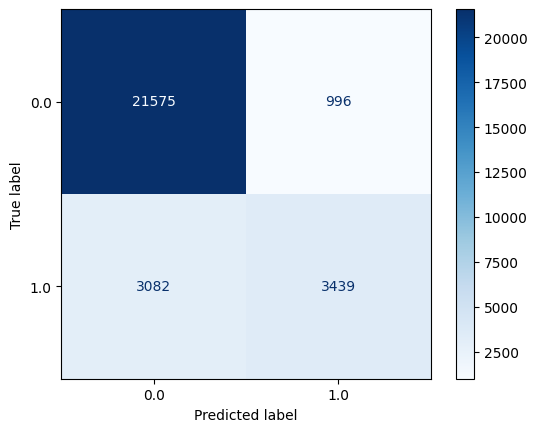

<Figure size 1200x1200 with 0 Axes>

In [21]:
cm=confusion_matrix(y_test, y_pred_by_hand)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.figure(figsize=(12, 12))
plt.show()

In [22]:
recall_s = recall_score(y_test, y_pred_by_hand, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall_s[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall_s[0])

Tỉ lệ dự đoán đúng ngày mai có mưa là  0.5273731022849256
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 0.9558725798591112


### 2.2 Resampled

In [23]:
y_train_resampled.values

array([0., 0., 0., ..., 1., 1., 1.])

In [24]:
dt_res_by_hand=CustomDecisionTree(max_depth=10, batch_size=1024, n_jobs=4)
dt_res_by_hand.fit(X_train_resampled.values, y_train_resampled.values)

# Dự đoán trên tập Test
start_time = time.time()
y_pred_by_hand = dt_res_by_hand.predict(X_test_resampled)
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")
acc = accuracy_score(y_test, y_pred_by_hand) * 100
result_acc.append(acc)
print(f"Accuracy on Test set: {acc:.2f}%")

Time to predict: 8.0360 seconds
Accuracy on Test set: 77.58%


In [25]:
y_pred_by_hand = dt_res_by_hand.predict(X_test_resampled)
print(y_pred_by_hand)
print(classification_report(y_test, y_pred_by_hand))

[0. 0. 0. ... 0. 0. 0.]
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.87     22571
         1.0       0.00      0.00      0.00      6521

    accuracy                           0.78     29092
   macro avg       0.39      0.50      0.44     29092
weighted avg       0.60      0.78      0.68     29092



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


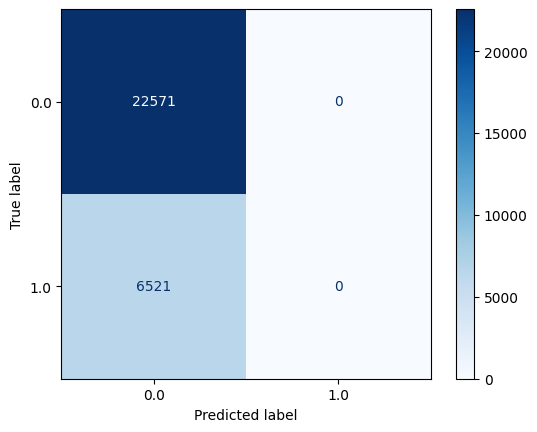

<Figure size 1200x1200 with 0 Axes>

In [26]:
cm=confusion_matrix(y_test, y_pred_by_hand)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.figure(figsize=(12, 12))
plt.show()

In [27]:
recall_s = recall_score(y_test, y_pred_by_hand, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall_s[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall_s[0])

Tỉ lệ dự đoán đúng ngày mai có mưa là  0.0
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 1.0


## 3. Model comparing

In [28]:
result_acc

[85.15055685411798, 82.69283651863056, 85.98240065997526, 77.58490306613503]

In [29]:
result_recall

[array([0.93442913, 0.56448397]), array([0.85685171, 0.72335531])]

In [30]:
pred_time

[0.007065534591674805,
 0.009406805038452148,
 184.8607201576233,
 8.035959243774414]

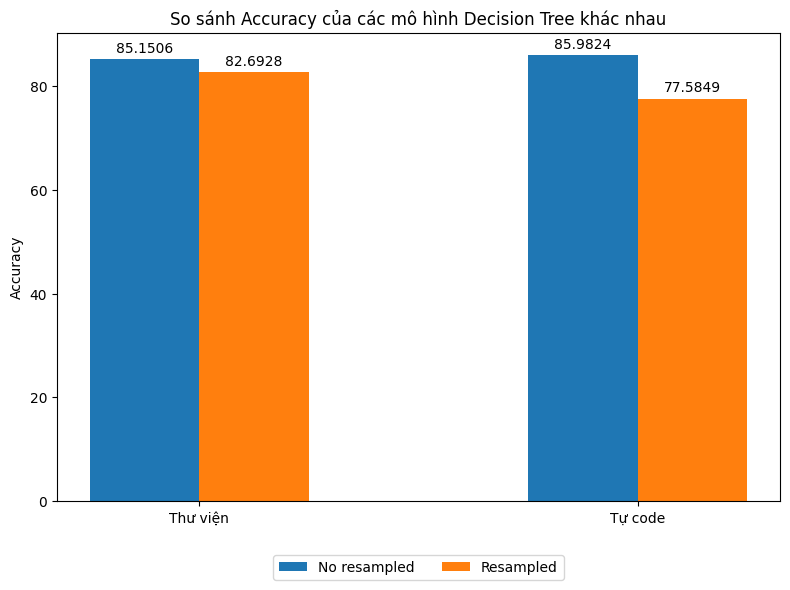

In [31]:
labels = ['Thư viện', 'Tự code']
no_res = [result_acc[0], result_acc[2]]
res = [result_acc[1], result_acc[3]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, no_res, width, label='No resampled')
rects2 = ax.bar(x + width/2, res, width, label='Resampled')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('So sánh Accuracy của các mô hình Decision Tree khác nhau')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

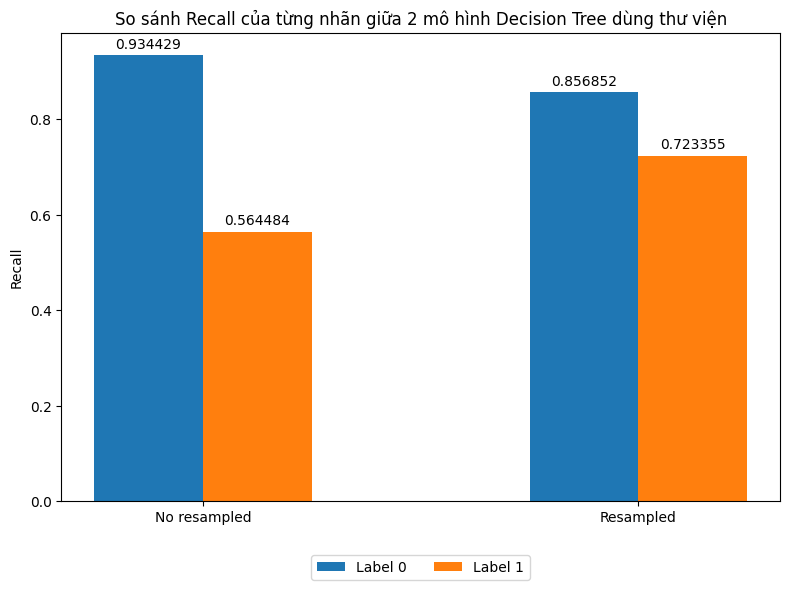

In [32]:
labels = ['No resampled', 'Resampled']
label_0 = [result_recall[0][0], result_recall[1][0]]
label_1 = [result_recall[0][1], result_recall[1][1]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, label_0, width, label='Label 0')
rects2 = ax.bar(x + width/2, label_1, width, label='Label 1')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Recall')
ax.set_title('So sánh Recall của từng nhãn giữa 2 mô hình Decision Tree dùng thư viện')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

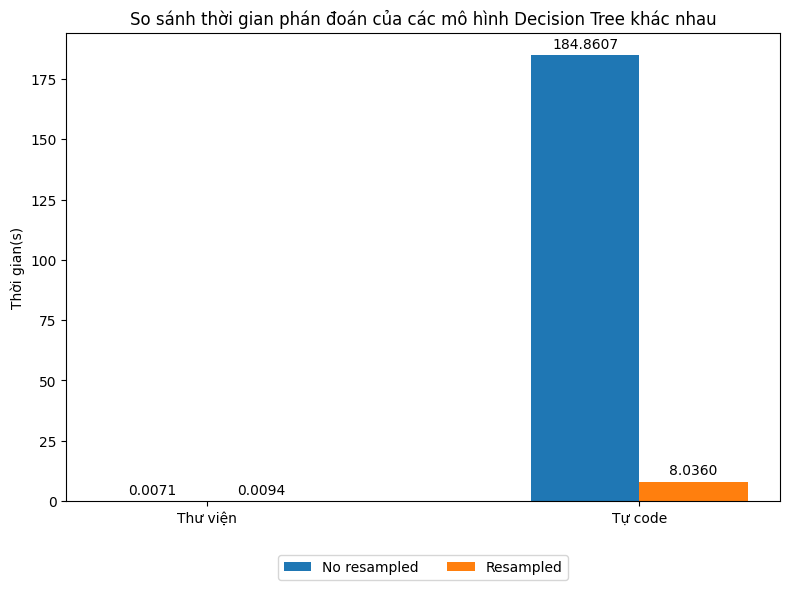

In [33]:
labels = ['Thư viện', 'Tự code']
no_res = [pred_time[0], pred_time[2]]
res = [pred_time[1], pred_time[3]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, no_res, width, label='No resampled')
rects2 = ax.bar(x + width/2, res, width, label='Resampled')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Thời gian(s)')
ax.set_title('So sánh thời gian phán đoán của các mô hình Decision Tree khác nhau')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3, labels=[f"{value:.4f}" for value in no_res])
ax.bar_label(rects2, padding=3, labels=[f"{value:.4f}" for value in res])

fig.tight_layout()

plt.show()

In [34]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Result/Model_Evaluation/5. Decision Tree.pkl'
with open(file_path, 'wb') as f:
    pickle.dump([result_acc,result_recall,pred_time],f)

Mounted at /content/drive
